# Uncertainty Estimation of CNN Image Segmentation
In this notebook we will estimate the epistemic uncertainty present in the dataset, after applying a CNN classifier model to perform image segmentation on the given "satellite images of water bodies" dataset. The model is based on the well-known UNet architecture, but modified for the purposes of uncertainty estimation.

The notebook is structured the following way;

## Table of Contents
- Data Preparation & Exploration
- Model Design
- Training
- Uncertainty Estimation
- Summary

# Data Preparation & Exploration

First we are going to access the file paths and store the location of the input data.

In [1]:
import numpy as np 
import pandas as pd
import re
import os

data_root = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

ids_ = []

# store all file numbers
for dirname, _, filenames in os.walk(data_root + "/Images"):
    for filename in filenames:
        s = re.findall('[0-9]+', filename)
        if type(s) == list and len(s):
            ids_.append(int(s[0]))

# split
ids = {}
train_test_ratio = 0.8
ids["train"] = ids_[:int(train_test_ratio*len(ids_))]
ids["test"]  = ids_[int(train_test_ratio*len(ids_)):]
del ids_

# make path generators
def getFullPath(i, mode="input"):
    if mode == "input":
        return os.path.join(data_root,f"Images/water_body_{i}.jpg")
    elif mode == "output":
        return os.path.join(data_root,f"Masks/water_body_{i}.jpg")
    else:
        raise ValueException("Invalid mode")

print(f"Acquired {len(ids['train'])} training samples")
print(f"Acquired {len(ids['test'])} test samples")

Acquired 2272 training samples
Acquired 569 test samples


Let's have a look at some of the images in the dataset.

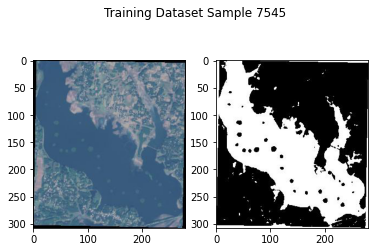

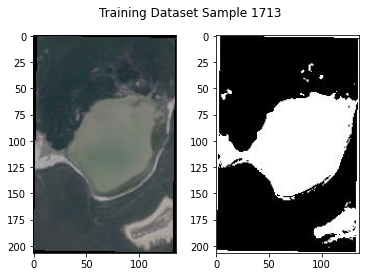

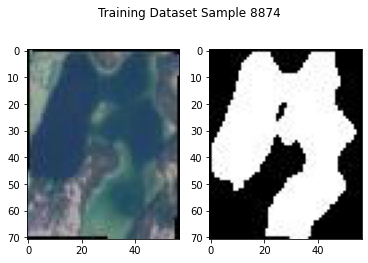

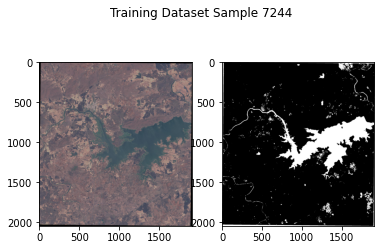

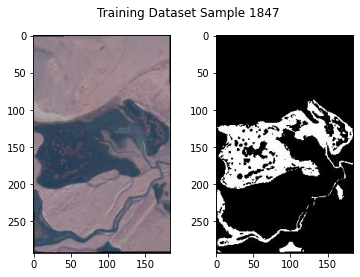

In [2]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np

def showImg(idx):
    plt.figure()
    plt.subplot(121)
    plt.imshow(image.imread(getFullPath(ids["test"][idx])))
    plt.subplot(122)
    plt.imshow(image.imread(getFullPath(ids["test"][idx],"output")))
    plt.suptitle(f"Training Dataset Sample {ids['test'][idx]}")
    
for i in range(5):
    idx = int(len(ids["test"]) * np.random.rand())
    showImg(idx)

There seem to be some irregularly shaped or label data. Let's have a look on the distribution of size and mean label in the dataset.

In [3]:
mean_labels = []
heights = []
widths = []

for idx in ids["train"]+ids["test"]:
    img = image.imread(getFullPath(idx,"output"))
    mean_labels.append(np.mean(np.array(img)))
    widths.append(img.shape[0])
    heights.append(img.shape[1])

Text(0.5, 0, 'Image Height')

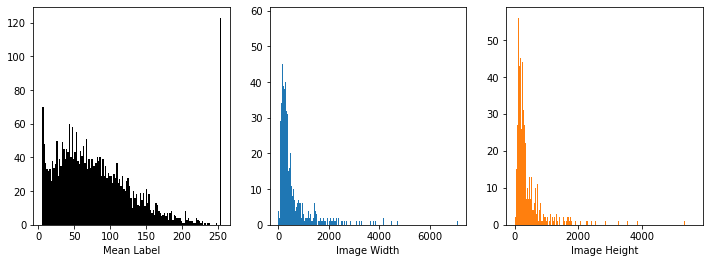

In [4]:
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.hist(mean_labels,bins=128,color="k")
plt.xlabel("Mean Label")

plt.subplot(132)
plt.hist(widths,bins=1024,color="C0")
plt.xlabel("Image Width")

plt.subplot(133)
plt.hist(heights,bins=1024,color="C1")
plt.xlabel("Image Height")

It seems that there are some 120 data points where the image label mask is completely white (255). These cases seem to be labeled wrong in many cases, thus should be excluded from the training. However, we will keep them in the dataset for now.

For training and testing purposes a data generator is built.

In [5]:
import numpy as np
from tensorflow import keras
from PIL import Image

def load_img(index, mode):
    path = getFullPath(index, mode)
    return Image.open(path)

def resize_img(img, new_dims):
    # calc new dims to preserve aspect
    ratios = np.divide(new_dims,img.size)
    min_ratio = np.min(ratios)
    dims = np.multiply(img.size,min_ratio).astype(int)
    # resize
    if dims[0] < 1:
        dims[0] = 1
    if dims[1] < 1:
        dims[1] = 1
    return img.resize(dims, Image.ANTIALIAS)

def pad_img(img, new_dims):
    offset = [0, 0]
    if new_dims[0] > img.size[0]:
        offset[0] = int((new_dims[0]-img.size[0])/2)
    if new_dims[1] > img.size[1]:
        offset[1] = int((new_dims[1]-img.size[1])/2)
    img_ = Image.new('RGB', new_dims)
    img_.paste(img,offset)
    return img_


def crush_img(img):
    """ reduces 3 channels into one, we skip fancy gamma compression for speed """
    # return np.mean(img, axis=2)
    # actually that is not necessary since the three channels are identical
    return img[:,:,0]

def rescale_img(img):
    return img/255

def preprocess_img(img, new_dims):
    img = resize_img(img, new_dims)
    img = pad_img(img, new_dims)
    img = rescale_img(np.asarray(img))
    return img

class DataGenerator(keras.utils.Sequence):
    """
       Generates training and test data on the fly.
    """
    def __init__(self, ids, batch_size=32, dim=(128,128), shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.ids = ids
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """ returns the number of batches in the given dataset """
        return int(len(self.ids) / self.batch_size)

    def __getitem__(self, idx):
        """ generate a batch """
        ids_batch = self.ids[idx*self.batch_size:(idx+1)*self.batch_size]
        X, Y = self.__data_generation(ids_batch)
        return X, Y

    def on_epoch_end(self):
        """ shuffle dataset after epoch """
        if self.shuffle == True:
            np.random.shuffle(self.ids)

    def __data_generation(self, ids_batch):
        """ reads data and generates X and Y """
        # input 3-channel RGB image, variable dimension
        # output 1-channel binary image, same dimension
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.empty((self.batch_size, *self.dim, 1))

        # generate batch
        for i, idx in enumerate(ids_batch):
            # store input
            img_ = load_img(idx, "input")
            img_ = preprocess_img(img_, self.dim)
            X[i,] = img_
            # store output
            img_ = load_img(idx, "output")
            img_ = preprocess_img(img_, self.dim)
            Y[i,] = crush_img(img_).reshape(*self.dim,1)

        return X, Y

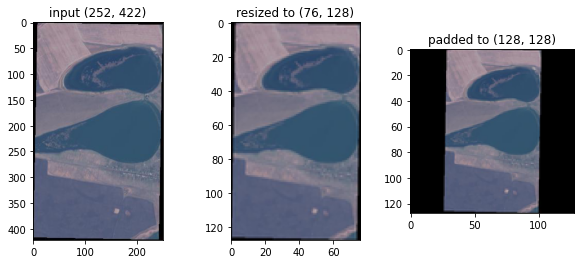

In [6]:
"""
    lets check out some preprocessed padded images
"""
new_dims = (128,128)

plt.figure(figsize=(10,4))

img = load_img(ids["train"][3],"input")
plt.subplot(131)
plt.imshow(img)
plt.title(f"input {img.size}")

img = resize_img(img, new_dims)
plt.subplot(132)
plt.imshow(img)
plt.title(f"resized to {img.size}")

img = pad_img(img, new_dims)
plt.subplot(133)
plt.imshow(img)
_ = plt.title(f"padded to {img.size}")

# Model Design
For the given image segmentation problem, we are implementing a miniaturized version of the U-Net Model as proposed by [[Ronneberger2015](https://arxiv.org/pdf/1505.04597.pdf)]. 

However, we will use smaller maps, less convolutions and a set of spatial dropout layers for later access to the epistemic uncertainty of our model.

In [7]:
from tensorflow import keras

class UNetModel(keras.Model):
    def __init__(self, dropout=0):
        
        super(UNetModel, self).__init__()
        
        self.layers_ = []
        
        # contraction 1
        self.layers_.append(("conv1_1",keras.layers.Conv2D(filters = 64,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        if dropout:
            self.layers_.append(("sp_dp",keras.layers.SpatialDropout2D(dropout)))
        self.layers_.append(("conv1_2",keras.layers.Conv2D(filters = 64,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        self.layers_.append(("conv1_pool",keras.layers.MaxPooling2D(pool_size = (2,2))))
        # contraction 2
        self.layers_.append(("conv2_1",keras.layers.Conv2D(filters = 128,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        if dropout:
            self.layers_.append(("sp_dp",keras.layers.SpatialDropout2D(dropout)))
        self.layers_.append(("conv2_2",keras.layers.Conv2D(filters = 128,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        self.layers_.append(("conv2_pool",keras.layers.MaxPooling2D(pool_size = (2,2))))
        # contraction 3
        self.layers_.append(("conv3_1",keras.layers.Conv2D(filters = 128,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        if dropout:
            self.layers_.append(("sp_dp",keras.layers.SpatialDropout2D(dropout)))
        self.layers_.append(("conv3_2",keras.layers.Conv2D(filters = 256,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        self.layers_.append(("conv3_pool",keras.layers.MaxPooling2D(pool_size = (2,2))))
        # core
        self.layers_.append(("conv4_1",keras.layers.Conv2D(filters = 512,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        if dropout:
            self.layers_.append(("sp_dp",keras.layers.SpatialDropout2D(dropout)))
        self.layers_.append(("conv4_2",keras.layers.Conv2D(filters = 512,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        # expansion 1
        self.layers_.append(("conv5_ups",keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")))
        self.layers_.append(("conv5_1",keras.layers.Conv2D(filters = 256,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        if dropout:
            self.layers_.append(("sp_dp",keras.layers.SpatialDropout2D(dropout)))
        self.layers_.append(("conv5_2",keras.layers.Conv2D(filters = 256,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        # expansion 2
        self.layers_.append(("conv6_ups",keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")))
        self.layers_.append(("conv6_1",keras.layers.Conv2D(filters = 128,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        if dropout:
            self.layers_.append(("sp_dp",keras.layers.SpatialDropout2D(dropout)))
        self.layers_.append(("conv6_2",keras.layers.Conv2D(filters = 128,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        # expansion 3
        self.layers_.append(("conv7_ups",keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")))
        self.layers_.append(("conv7_1",keras.layers.Conv2D(filters = 64,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        if dropout:
            self.layers_.append(("sp_dp",keras.layers.SpatialDropout2D(dropout)))
        self.layers_.append(("conv7_2",keras.layers.Conv2D(filters = 64,
                                                          kernel_size = (3,3),
                                                          activation = "relu",
                                                          padding = "same")))
        # final layer
        self.layers_.append(("conv8_final",keras.layers.Conv2D(filters = 1,
                                                              kernel_size = (1,1),
                                                              activation = "sigmoid",
                                                              padding = "same")))
    
    def call(self, x, training=False):
        
        merge_from  = ["conv1_2","conv2_2","conv3_2"]
        merge_to    = ["conv7_1","conv6_1","conv5_1"]
        buffer      = {}
        
        for name, layer in self.layers_:
            if name in merge_to:
                idx = merge_to.index(name)
                x = keras.layers.Concatenate(axis=3)([buffer[merge_from[idx]],x])
                
            if name == "sp_dp":
                x = layer(x, training)
            else:
                x = layer(x)
            
            if name in merge_from:
                buffer[name] = x
        
        return x

# Training
The model is training using a Nadam Optimizer, early stopping and learning rate reduction. Upon 8 epochs without increase in test performance the training will be stopped. The model is built with 50% spatial dropout.

2021-12-23 18:36:14.826192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 18:36:14.944745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 18:36:14.945527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 18:36:14.946743: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "u_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
spatial_dropout2d (SpatialDr multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
spatial_dropout2d_1 (Spatial multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  

2021-12-23 18:36:18.309411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-12-23 18:36:23.210078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


71/71 [==============================] - 107s 1s/step - loss: 0.5578 - val_loss: 0.4422
Epoch 2/100
71/71 [==============================] - 77s 1s/step - loss: 0.4838 - val_loss: 0.4450
Epoch 3/100
71/71 [==============================] - 77s 1s/step - loss: 0.4772 - val_loss: 0.4323
Epoch 4/100
71/71 [==============================] - 77s 1s/step - loss: 0.4982 - val_loss: 0.4509
Epoch 5/100
71/71 [==============================] - 77s 1s/step - loss: 0.4716 - val_loss: 0.4327
Epoch 6/100
71/71 [==============================] - 77s 1s/step - loss: 0.4853 - val_loss: 0.4249
Epoch 7/100
71/71 [==============================] - 76s 1s/step - loss: 0.4600 - val_loss: 0.4134
Epoch 8/100
71/71 [==============================] - 77s 1s/step - loss: 0.4479 - val_loss: 0.4020
Epoch 9/100
71/71 [==============================] - 77s 1s/step - loss: 0.4646 - val_loss: 0.4171
Epoch 10/100
71/71 [==============================] - 76s 1s/step - loss: 0.4551 - val_loss: 0.4395
Epoch 11/100
71/71 [

2021-12-23 19:48:34.337420: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Conv2D     # params:       1792, mean w: -0.0532, mean b:  -0.00142
Conv2D     # params:      36928, mean w: -0.0128, mean b:  -0.00177
Conv2D     # params:      73856, mean w: -0.0077, mean b:  -0.01397
Conv2D     # params:     147584, mean w: -0.0067, mean b:  -0.01921
Conv2D     # params:     147584, mean w: -0.0047, mean b:  -0.01342
Conv2D     # params:     295168, mean w: -0.0071, mean b:  -0.02086
Conv2D     # params:    1180160, mean w: -0.0032, mean b:  -0.01716
Conv2D     # params:    2359808, mean w: -0.0041, mean b:  -0.01913
Conv2D     # params:    1769728, mean w: -0.0026, mean b:  -0.02060
Conv2D     # params:     590080, mean w: -0.0068, mean b:  -0.03178
Conv2D     # params:     442496, mean w: -0.0026, mean b:  -0.01424
Conv2D     # params:     147584, mean w: -0.0094, mean b:  -0.02757
Conv2D     # params:     110656, mean w: -0.0039, mean b:  0.02690
Conv2D     # params:      36928, mean w: -0.0101, mean b:  0.13047
Conv2D     # params:         65, mean w: -0.0604, 

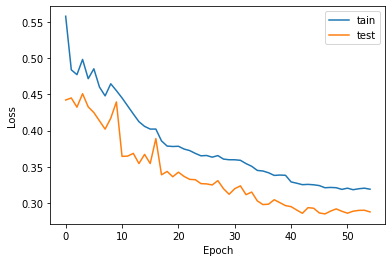

In [8]:
import tensorflow as tf

""" setup model """
model = UNetModel(dropout=0.5)
model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = keras.optimizers.Nadam()
)
model.build(input_shape=(None,128,128,3))
model.summary()

""" train or load """
mode = "train_new" # or "train_new"

if mode == "train_new":
    # grab datasets
    training_generator = DataGenerator(ids['train'])
    validation_generator = DataGenerator(ids['test'])

    # early stopping and plateau exit
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
    lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

    # train
    history = model.fit(x=training_generator, 
                        validation_data=validation_generator, 
                        batch_size=32, 
                        epochs=100, 
                        callbacks=[early_stopping, lr_reduce])

    # save model
    from datetime import datetime
    now = datetime.now().isoformat()
    model.save(f"/kaggle/working/{now}_{history.history['loss'][-1]}.checkpoint")

    # plot training history
    plt.plot(history.history["loss"], label="tain")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend()
    plt.xlabel("Epoch")
    _ = plt.ylabel("Loss")
    
elif mode == "load":
    model.load_weights("/kaggle/input/unet-model-waterbodies-spatial-dropout/2021-12-20T10:34:14.105393_0.23699867725372314.checkpoint")
    
""" check model weights """
for layer in model.layers:
    w = layer.get_weights()
    if len(w):
        print(f"{type(layer).__name__:10s} # params: {w[0].size+w[1].size:10d}, mean w: {np.mean(w[0]):.4f}, mean b:  {np.mean(w[1]):.5f}")

During training the model is converging towards a plateau. Overfitting is successfully prevented, due to the induced early stopping callback. The model weights are stable, no vanishing weights or unutilized layer are spotted upon first glance.

In [9]:
"""
# optional code to save the model weights
import shutil
shutil.make_archive("/kaggle/working/model.zip", 'zip', "/kaggle/working")
"""

'\n# optional code to save the model weights\nimport shutil\nshutil.make_archive("/kaggle/working/model.zip", \'zip\', "/kaggle/working")\n'

# Uncertainty Quantification
Activating the implemented spatial dropout within the model during inference let's us simulate an ensemble of models. This way we can use the model as an bayesian approximator to estimate the epistemic uncertainty present in this case study. This let's us visualize areas which are less confidently classified, based on lack of represantive training samples in the dataset.

The predictable uncertainty (PU) of any given problem can be separated into its epistemic (EU) and aleatoric uncertainty (AU) [[Abdar2021](https://arxiv.org/abs/2011.06225)].
\begin{equation}
    \text{PU} = \text{EU} + \text{AU}
\end{equation}

Sampling the model multiple times with dropout enabled, while using the same input, makes it possible to calculate the standard derivation $\sigma_c$ of the models classfication. High derivation means more uncertainty and vice versa. A result should only be trusted if its $\sigma_c \leq \epsilon$. Where $\epsilon$ is a arbitrarily selected confidence boundary.

We first sort the test dataset by the achieved loss (binary cross entropy) to highlight particularly well, or bad, test cases.

In [10]:
losses = []

bce = keras.losses.BinaryCrossentropy()

# obtain test losses
for idx in ids['test']:
    # load
    img_in = load_img(idx,"input")
    img_out = load_img(idx,"output")
    # preprocess
    img_in = preprocess_img(img_in, (128,128)).reshape(1,128,128,3)
    img_out = crush_img(preprocess_img(img_out, (128,128)))
    # call model
    img_out_pred = model.call(img_in, training = False).numpy().squeeze()
    # calc loss
    loss = bce(img_out, img_out_pred)
    losses.append((idx,loss.numpy()))

# sort by value
losses.sort(key= lambda x: x[1])

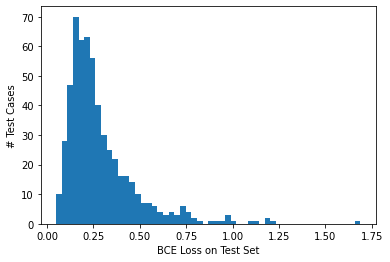

In [11]:
losses_ = [l for (idx,l) in losses]
plt.figure()
plt.hist(losses_,bins=54)
plt.ylabel("# Test Cases")
_ = plt.xlabel("BCE Loss on Test Set")

Seems like the majority of cases are being more or less equally well classified. The median and mean of the distribution of classified test cases is pushed far towards 0.

If we now reactivate the spatial dropout during inference we can sample multiple inferences for the same input and then calculate the standard deviation to visualize the epistemic uncertainty of the model. For this we adapt the display testcase function as follows.

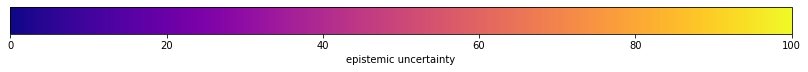

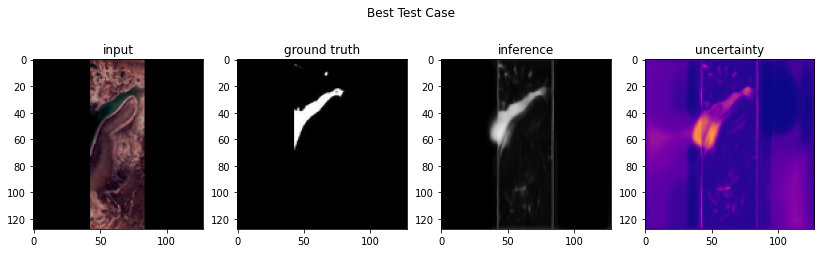

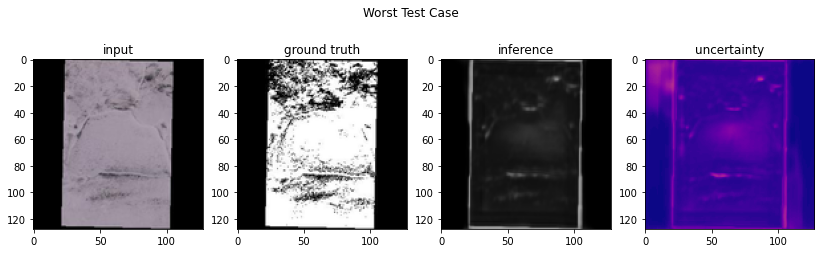

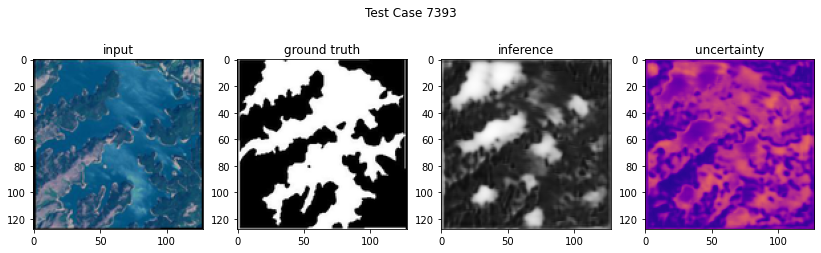

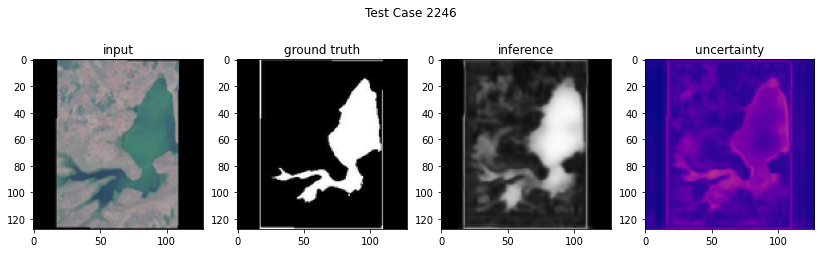

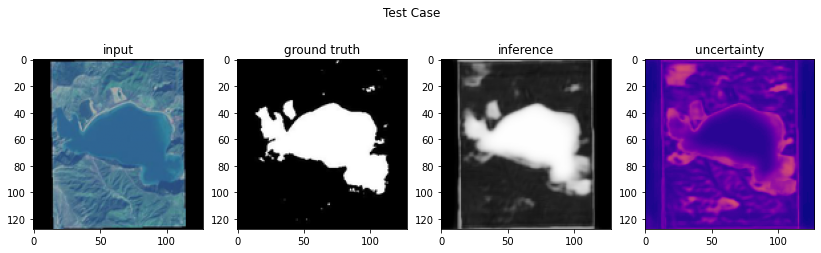

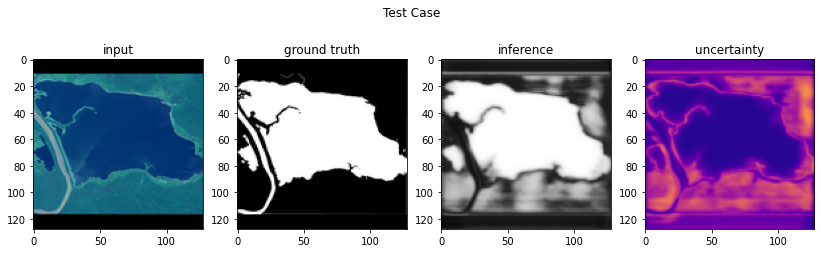

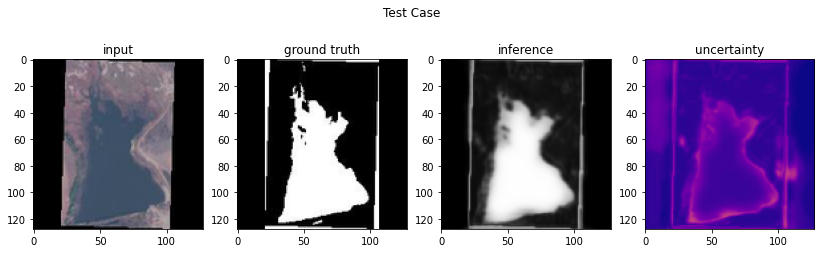

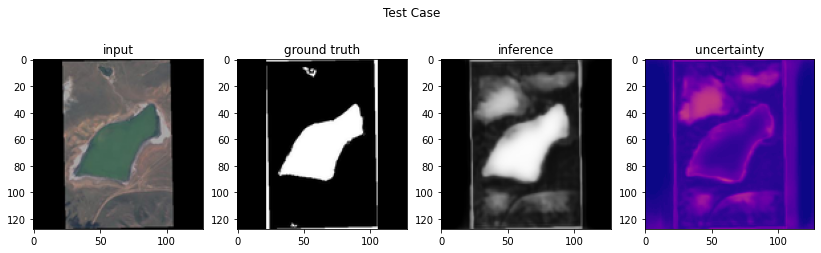

In [12]:
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=100)

def displayTestcaseWithUncertainty(idx, n_samples=100, string=""):
    
    img_in = preprocess_img(load_img(idx,"input"), (128,128))
    img_out = preprocess_img(load_img(idx,"output"), (128,128))
    
    img_out_pred = model.call(img_in.reshape(1,128,128,3)).numpy()
    img_out_pred = Image.fromarray(np.uint8(np.multiply(cm.gray(img_out_pred.squeeze()),255)))
    
    samples = []
    for n in range(n_samples):
        samples.append(model.call(img_in.reshape(1,128,128,3), training=True).numpy())
    samples = np.stack(samples, axis=0)
    stds = np.std(samples, axis=0)
    stds = Image.fromarray(np.uint8(np.multiply(stds.squeeze(),255)))
    
    plt.figure(figsize=(14,4))
    plt.subplot(141)
    plt.imshow(img_in)
    plt.title("input")
    
    plt.subplot(142)
    plt.imshow(img_out)
    plt.title("ground truth")
    
    plt.subplot(143)
    plt.imshow(img_out_pred)
    plt.title("inference")
    
    plt.subplot(144)
    plt.imshow(stds, cmap=cmap, norm=norm)
    plt.title("uncertainty")

    plt.suptitle(string)  
    
fig, ax = plt.subplots(figsize=(14,0.5))
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax,
    orientation='horizontal',
    label='epistemic uncertainty'
)
    
displayTestcaseWithUncertainty(losses[0][0], string="Best Test Case")
displayTestcaseWithUncertainty(losses[-2][0], string="Worst Test Case")
displayTestcaseWithUncertainty(7393, string="Test Case 7393")
displayTestcaseWithUncertainty(2246, string="Test Case 2246")
displayTestcaseWithUncertainty(losses[180][0], string="Test Case")
displayTestcaseWithUncertainty(21, string="Test Case")
displayTestcaseWithUncertainty(losses[103][0], string="Test Case")
displayTestcaseWithUncertainty(losses[207][0], string="Test Case")

# Summary
The epistemic uncertainity shows that the model is very certain for large continous bodies of water. As expected the uncertainty raises towards the edges of the class boundary. Many cases show difficult areas to classify, where even the label is not well put. Yet, the epistemic uncertainty is a very useful tool to determine the quality of the classification even if the ground truth is unknown.

Furthermore, acquiring the aleatoric uncertainty of the data needs to be done by different means. It is defined as:
- homoscedastic aleatoric uncertainty, if it applies to all data equally. Example: Noise across all values.
- heteroscedastic aleatoric uncertainty, if it applies to local areas in the data. Example: Doppler-shift of certain objects in astronomic observations.

For the former, additional free parameters can be added to the model to transform the input data homogenously (example, mean and std). For the latter, a specific loss function can be used to acquire the input-dependent mean and std. Thus, we will need to fit a second model.


